In [2]:
# this project looks at whether or not there has been a positive impact from Austin Reaves in terms of the lakers
# performance during his 5 year period with the team
# This will be done using advanced metrics as in the input variables - Box Plus minus, Minutes Per Possession, and Defensive Win shares
# The output variable will be the Lakers overall yearly performance with Austin Reaves

In [3]:
# installing packages for regression
# This contains Ridge and Lasso regressions which control for multicolinearity
# pip install scikit-learn

## Step 1: Importing Libraries for Cleaning, Regression and Visualisation

In [4]:
# This is to import all the packages I will need for the analysis
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LassoCV

## Step 2: Importing Lakers Team Data and Cleaning it

In [5]:
# first I need to import each of the csvs for each season and combine them into one dataframe 

# imported data
Lakers2021_2022 = pd.read_csv("Lakers 2021-2022.csv")
Lakers2022_2023 = pd.read_csv("Lakers 2022-2023.csv")
Lakers2023_2024 = pd.read_csv("Lakers 2023-2024.csv")
Lakers2024_2025 = pd.read_csv("Lakers 2024-2025.csv")

# adding all the data to one dataframe
Lakers_df = pd.concat([Lakers2021_2022,Lakers2022_2023,Lakers2023_2024,Lakers2024_2025], ignore_index=True)
Lakers_df = Lakers_df.reset_index(drop=True)
Lakers_df.head(5)

,Rk,Gtm,Date,Unnamed: 3,Opp,Rslt,Tm,Opp.1,OT,FG,...,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF
0,1,1,19/10/21,NaN,GSW,L,114,121,NaN,45,...,19,0.474,5,40,45,21,7,4,18,25
1,2,2,22/10/21,NaN,PHO,L,105,115,NaN,34,...,29,0.759,12,34,46,25,7,3,16,26
2,3,3,24/10/21,NaN,MEM,W,121,118,NaN,45,...,22,0.682,9,27,36,29,10,12,17,14
3,4,4,26/10/21,@,SAS,W,125,121,OT,50,...,22,0.773,9,47,56,20,8,10,13,21
4,5,5,27/10/21,@,OKC,L,115,123,NaN,46,...,14,0.857,10,30,40,29,8,2,17,22


### Calculating Dependent Variable - Lakers Net Rating 

In [6]:
# Since I could only get the simple stats, I have to calculate the teams net rating 

# To start I need to get the possessions per game which is calculated using this formula
Lakers_df["Possessions"] = (Lakers_df["FGA"] + (0.44 * Lakers_df["FTA"]) - Lakers_df["ORB"] + Lakers_df["TOV"])
Lakers_df.head(5)

# now we can calculate the Lakers net rating using this formula
Lakers_df["Net Rating"] = 100 * ((Lakers_df["Tm"] - Lakers_df["Opp.1"]) / Lakers_df["Possessions"])
Lakers_df.head(5)

,Rk,Gtm,Date,Unnamed: 3,Opp,Rslt,Tm,Opp.1,OT,FG,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,Possessions,Net Rating
0,1,1,19/10/21,NaN,GSW,L,114,121,NaN,45,...,5,40,45,21,7,4,18,25,116.36,-6.015813
1,2,2,22/10/21,NaN,PHO,L,105,115,NaN,34,...,12,34,46,25,7,3,16,26,102.76,-9.731413
2,3,3,24/10/21,NaN,MEM,W,121,118,NaN,45,...,9,27,36,29,10,12,17,14,101.68,2.950433
3,4,4,26/10/21,@,SAS,W,125,121,OT,50,...,9,47,56,20,8,10,13,21,118.68,3.370408
4,5,5,27/10/21,@,OKC,L,115,123,NaN,46,...,10,30,40,29,8,2,17,22,105.16,-7.607455


## Step 3: Importing Austin Reaves Data and Cleaning it

In [7]:
Austin_2021_2022 = pd.read_csv("AustinReaves 2021-2022.csv")
Austin_2022_2023 = pd.read_csv("AustinReaves 2022-2023.csv")
Austin_2023_2024 = pd.read_csv("AustinReaves2023-2024.csv")
Austin_2024_2025 = pd.read_csv("AustinReaves 2024-2025.csv")

Austin_df = pd.concat([Austin_2021_2022,Austin_2022_2023,Austin_2023_2024,Austin_2024_2025])
Austin_df = Austin_df.reset_index(drop=True)
Austin_df.index.name = "Games"
Austin_df.head(5)

,Rk,Gcar,Gtm,Date,Team,Unnamed: 5,Opp,Result,GS,MP,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
Games,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,1.0,19/10/21,LAL,NaN,GSW,"L, 114-121",Did Not Play,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,2.0,22/10/21,LAL,NaN,PHO,"L, 105-115",NaN,12:00,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,6.0,17.0
2,2.0,2.0,3.0,24/10/21,LAL,NaN,MEM,"W, 121-118",NaN,17:50,...,0.0,0.0,3.0,0.0,0.0,0.0,1.0,4.0,4.4,18.0
3,3.0,3.0,4.0,26/10/21,LAL,@,SAS,"W, 125-121 (OT)",NaN,30:13:00,...,2.0,2.0,1.0,0.0,0.0,2.0,3.0,10.0,5.8,-13.0
4,4.0,4.0,5.0,27/10/21,LAL,@,OKC,"L, 115-123",NaN,17:46,...,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.2,-5.0


## Step 4: Calculating the Advanced Stats - MPP, BPM, DWS

These next two cells simply contain visualisations for Austin's basic stats during his time with the Lakers.
In order for me to create the visualisation, I had to extract the year from the date which required changing the date format.
With this changed date format, it impacted how I merged the Lakers dataframe and Austin Reaves Dataframe, so I decided it was 
best to comment the code out. 

In [8]:
#Austin_df['Date'] = pd.to_datetime(Austin_df['Date'], dayfirst=True, errors='coerce')
#Austin_df['Year'] = Austin_df['Date'].dt.year
#Austin_df['Year'] = Austin_df['Year'].fillna(0).astype(int)
#Austin_df

In [9]:
# I want to show some trends of Austins basic stats over all the games he has played for the Lakers
# Austin_df.groupby('Year')[["PTS","AST","TRB","STL"]].mean().plot(kind='line', marker='o', figsize=(10,6))
# plt.title("Trend Line of Austin Reaves Basic Stats During Time with Lakers")

In [10]:
#Austin_df.groupby('Year')[["PTS","AST","TRB","STL","Minutes"]].mean().plot(kind='line', marker='o', figsize=(10,6))
#plt.title("Trend Line of Austin Reaves Basic Stats During Time with Lakers")

### Calculating Minutes Per Possession (MPP)

In [11]:
# First I needed to calculate possessions used for Austin since I could only get it for his yearly data not game by game
Austin_df["Possessions_used"] = Austin_df["FGA"] + 0.44 * Austin_df["FTA"] + Austin_df["TOV"]
Austin_df.head(5)

,Rk,Gcar,Gtm,Date,Team,Unnamed: 5,Opp,Result,GS,MP,...,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-,Possessions_used
Games,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,1.0,19/10/21,LAL,NaN,GSW,"L, 114-121",Did Not Play,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1,1.0,1.0,2.0,22/10/21,LAL,NaN,PHO,"L, 105-115",NaN,12:00,...,0.0,0.0,0.0,0.0,0.0,1.0,8.0,6.0,17.0,4.00
2,2.0,2.0,3.0,24/10/21,LAL,NaN,MEM,"W, 121-118",NaN,17:50,...,0.0,3.0,0.0,0.0,0.0,1.0,4.0,4.4,18.0,3.00
3,3.0,3.0,4.0,26/10/21,LAL,@,SAS,"W, 125-121 (OT)",NaN,30:13:00,...,2.0,1.0,0.0,0.0,2.0,3.0,10.0,5.8,-13.0,7.88
4,4.0,4.0,5.0,27/10/21,LAL,@,OKC,"L, 115-123",NaN,17:46,...,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.2,-5.0,4.00


The next component required for calculating minutes per possession is the minutes Austin played for each game. In order to get the minutes, I had to change the format of the "MP" column from a time stamp to a float. This required a function as shown below. I was then able to calculate the Minutes Per Possession stat. 

In [12]:


# defining the function where x is simply the time stamp from a given game
def mp_to_minutes(x):
    # if Austin didn't play a game, the value returned will be Nan so that there is no error 
    # when running the function 
    if pd.isna(x):
        return np.nan

    # This strips the time stamp of any other pieces so that it can be split below
    x = str(x).strip()
    # splitting the time into two parts where there is a colon
    parts = x.split(':')
    
    try:
        # this if statement is for if the time stamp follows a MM:SS format
        if len(parts) == 2:  
            minutes = int(parts[0])
            seconds = float(parts[1])
            return minutes + seconds / 60

        # this statement is for if the time stamp is formatted MM:SS:MS
        elif len(parts) == 3:  # MM:SS:MS (milliseconds)
            minutes = int(parts[0])
            seconds = int(parts[1])
            milliseconds = float(parts[2])
            return minutes + seconds / 60 + milliseconds / 1000 / 60

        # if the time stamp only shows the minutes or MM
        elif len(parts) == 1:  
            return float(parts[0])
        
        else:
            return np.nan  # unexpected format
    except:
        return np.nan 

# this peice puts the function into action using the apply function from pandas
Austin_df["Minutes"] = Austin_df["MP"].apply(mp_to_minutes)
Austin_df.head(5)

# with all the pieces, the MPP stat can be calculated 
Austin_df["MPP"] = Austin_df["Minutes"]/Austin_df["Possessions_used"]
Austin_df.head(5)

,Rk,Gcar,Gtm,Date,Team,Unnamed: 5,Opp,Result,GS,MP,...,STL,BLK,TOV,PF,PTS,GmSc,+/-,Possessions_used,Minutes,MPP
Games,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,1.0,19/10/21,LAL,NaN,GSW,"L, 114-121",Did Not Play,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,NaN
1,1.0,1.0,2.0,22/10/21,LAL,NaN,PHO,"L, 105-115",NaN,12:00,...,0.0,0.0,0.0,1.0,8.0,6.0,17.0,4.00,12.000000,3.000000
2,2.0,2.0,3.0,24/10/21,LAL,NaN,MEM,"W, 121-118",NaN,17:50,...,0.0,0.0,0.0,1.0,4.0,4.4,18.0,3.00,17.833333,5.944444
3,3.0,3.0,4.0,26/10/21,LAL,@,SAS,"W, 125-121 (OT)",NaN,30:13:00,...,0.0,0.0,2.0,3.0,10.0,5.8,-13.0,7.88,30.216667,3.834602
4,4.0,4.0,5.0,27/10/21,LAL,@,OKC,"L, 115-123",NaN,17:46,...,0.0,0.0,0.0,0.0,2.0,0.2,-5.0,4.00,17.766667,4.441667


### Calculating the Defensive Win Shares (DWS)

First I needed to combine the two data frames contain the Lakers and Austins data. This was for simplicity of calculating the defensive win shares as it uses a combination of individual player data and team data to be calculated. 

In [13]:
# This was simple as each date matched up exactly on both dataframes
Combined_df = pd.merge(Austin_df,Lakers_df, on="Date")
Combined_df.head(5)

,Rk_x,Gcar,Gtm_x,Date,Team,Unnamed: 5,Opp_x,Result,GS,MP,...,ORB_y,DRB_y,TRB_y,AST_y,STL_y,BLK_y,TOV_y,PF_y,Possessions,Net Rating
0,NaN,NaN,1.0,19/10/21,LAL,NaN,GSW,"L, 114-121",Did Not Play,0,...,5,40,45,21,7,4,18,25,116.36,-6.015813
1,1.0,1.0,2.0,22/10/21,LAL,NaN,PHO,"L, 105-115",NaN,12:00,...,12,34,46,25,7,3,16,26,102.76,-9.731413
2,2.0,2.0,3.0,24/10/21,LAL,NaN,MEM,"W, 121-118",NaN,17:50,...,9,27,36,29,10,12,17,14,101.68,2.950433
3,3.0,3.0,4.0,26/10/21,LAL,@,SAS,"W, 125-121 (OT)",NaN,30:13:00,...,9,47,56,20,8,10,13,21,118.68,3.370408
4,4.0,4.0,5.0,27/10/21,LAL,@,OKC,"L, 115-123",NaN,17:46,...,10,30,40,29,8,2,17,22,105.16,-7.607455


This cell of code calculates the defensive rating which is calculated using the number of points scored against the lakers (the opposing teams score in each game) and the possessions which was calculated before. From there I took the league average defensive rating and subtracted it from the lakers defensive rating to get the Lakers defensive win shares. Next I calculated the amount of time each game went accounting for overtimes. From there I was able to calculate Austins DWS.

In [14]:
# Calculating the defensive rating for the lakers 
Combined_df["Drtg"] = 100 * Combined_df["Opp.1"] / Combined_df["Possessions"]
Combined_df

# this is the league average defensive rating from 2021 to 2025 (the same time period the data is from)
League_Drtg = 103.94

# simple calculation to get the Lakers defensive win shares
Combined_df["Team_DWS"] = League_Drtg - Combined_df["Drtg"] 
Combined_df


# Since I want to find the average amount of playing time across the data I have, its fair to assume that each game is 4 12 min 
# quarters, so 327 games multiplied by 48 minutes + 24*5 (for the overtime)

# This counts how many times the games went into overtime
OT = Combined_df["OT"].count()
# Assuming that each game is 48 minutes and that there were 327 games, we multiply minutes and games then add the overtime in
# to calculate the average minutes
average_minutes = ((327*48) + (OT*5))/327
#print(average_minutes)

# All the pieces are here to calculate Austins defensive win shares
Combined_df["DWS"] = Combined_df["Team_DWS"] * (Combined_df["Minutes"] / average_minutes)
Combined_df.head(5)

,Rk_x,Gcar,Gtm_x,Date,Team,Unnamed: 5,Opp_x,Result,GS,MP,...,AST_y,STL_y,BLK_y,TOV_y,PF_y,Possessions,Net Rating,Drtg,Team_DWS,DWS
0,NaN,NaN,1.0,19/10/21,LAL,NaN,GSW,"L, 114-121",Did Not Play,0,...,21,7,4,18,25,116.36,-6.015813,103.987625,-0.047625,-0.000000
1,1.0,1.0,2.0,22/10/21,LAL,NaN,PHO,"L, 105-115",NaN,12:00,...,25,7,3,16,26,102.76,-9.731413,111.911250,-7.971250,-1.977692
2,2.0,2.0,3.0,24/10/21,LAL,NaN,MEM,"W, 121-118",NaN,17:50,...,29,10,12,17,14,101.68,2.950433,116.050354,-12.110354,-4.465195
3,3.0,3.0,4.0,26/10/21,LAL,@,SAS,"W, 125-121 (OT)",NaN,30:13:00,...,20,8,10,13,21,118.68,3.370408,101.954837,1.985163,1.240206
4,4.0,4.0,5.0,27/10/21,LAL,@,OKC,"L, 115-123",NaN,17:46,...,29,8,2,17,22,105.16,-7.607455,116.964625,-13.024625,-4.784343


## Step 5: Running the Regression Models 

### Creating a Simplified Dataframe

In [15]:
# now that I have all my variables for my regression analysis, I am going to put them into one table for simplicity

Combined_df["BPM"] =  Combined_df["+/-"]
regression_df = Combined_df[["Net Rating","DWS","MPP","BPM"]]
regression_df.head(5)

,Net Rating,DWS,MPP,BPM
0,-6.015813,-0.000000,NaN,0.0
1,-9.731413,-1.977692,3.000000,17.0
2,2.950433,-4.465195,5.944444,18.0
3,3.370408,1.240206,3.834602,-13.0
4,-7.607455,-4.784343,4.441667,-5.0


### Splitting Data into Train and Test Groups 

Before running the Ridge and Lasso regression models, I decided that it would be best to train my models first before testing it to get more accurate results. This also helps control for multicollinearity. In order to do this, I simply get my variables from my regression data frame and set them as X and y accordingly. From there I use the train test split function from skylearn and create my x and y train, and x and y test variables. 

In [16]:
# creating the x and y variables for the function inputs
X = regression_df[["DWS","MPP","BPM"]]
y = regression_df["Net Rating"]

# the actual function that splits the data in half randomly but in a repeatable way
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, shuffle=True)

# just testing to make sure this split was done
#print(X_train, y_train)
#print(X_test, y_test)

### Training and Testing the Ridge Regression Model

Note that I had to make some changes to my data to account for the missing values. The regression models could not be run if there were Nan values, since the models register them as infinite values. Once these "infinite" values were replaced, I could then impute these values with the mean of the column. For example, in the MPP, a game where Austin missed will be filled with his mean MPP. This was a better option than removing those empty data points. Once I fixed this, I was able to train my Ridge Model and then test it. 

In [17]:
# since my input variables are missing data aka Austin Reaves did not play that game, I will impute the data
# this essentially means that for the games that Austin missed, we will use the average of that column to fill the missing spots
# We need to import this package first
from sklearn.impute import SimpleImputer
# this helps for displaying the r square and mean square error for the regression models
from sklearn.metrics import mean_squared_error, r2_score

# then we need to replace the 0's, which are read by python as infinite values, with Nan
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# now we can replace the Nan's with the mean of the column 
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train)

# now we have clean input variables for the train model
# we will also clean up the test input variables now for simplicity
X_train_clean = imputer.transform(X_train)
X_test_clean = imputer.transform(X_test)

# this is the training part of the ridge regression
Ridge_model = Ridge(alpha=1.0)
Ridge_model.fit(X_train_clean,y_train)

# the next step is to make predictions for the output using the X training inputs
out_predict = Ridge_model.predict(X_test_clean)

# finally we test the performance of the trained model
r2 = r2_score(y_test, out_predict) 
mse = mean_squared_error(y_test,out_predict)

print(f"Y-intercept: {Ridge_model.intercept_}, R square: {r2}, mean square error: {mse}, Coefficients: {Ridge_model.coef_}")

Y-intercept: 5.086995202448859, R square: 0.47014886494201813, mean square error: 99.96947758292757, Coefficients: [ 0.54120406 -1.04190186  0.67844127]


### Plotting the Regressions for each Independent against Net Rating

Now that I have trained and tested the Ridge and Lasso models, I graphed each independent variable to see how well the correlate to the Lakers Net Rating. The Results are shown as below.

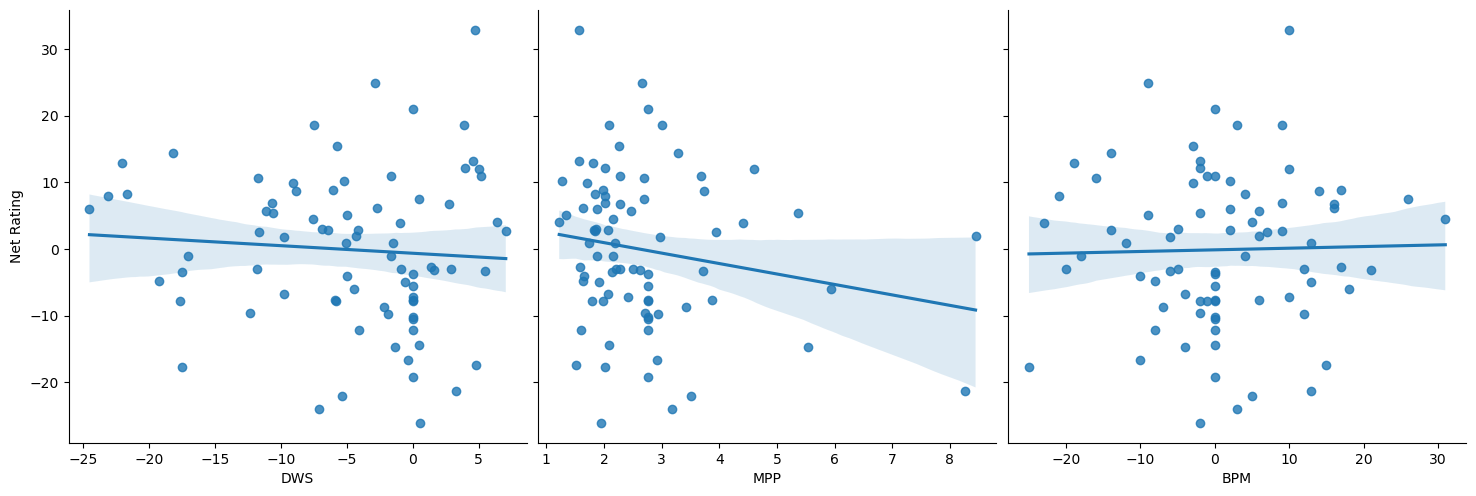

In [18]:
df_plot = pd.DataFrame(X_train_clean, columns=['DWS', 'MPP', 'BPM'])
df_plot['Net Rating'] = y_train

# 2. Create the plots
# 'kind="reg"' automatically adds the trendline
sns.pairplot(df_plot, x_vars=['DWS', 'MPP', 'BPM'], 
             y_vars='Net Rating', height=5, kind='reg')

plt.show()

In [19]:
# now we do the same thing for the lasso model
# it follows exactly the same steps with the only difference being an alpha of 0.01

Lasso_model = Lasso(alpha=0.01)
Lasso_model.fit(X_train_clean,y_train)

out_predict = Lasso_model.predict(X_test_clean)

r2 = r2_score(y_test,out_predict)
mse = mean_squared_error(y_test, out_predict)

print(f"Y-Intercept: {Lasso_model.intercept_}, R square: {r2}, mean square error: {mse}, Coefficients: {Lasso_model.coef_}")


Y-Intercept: 5.079901983308678, R square: 0.47030293901836184, mean square error: 99.94040771046335, Coefficients: [ 0.54103198 -1.03958663  0.67841971]


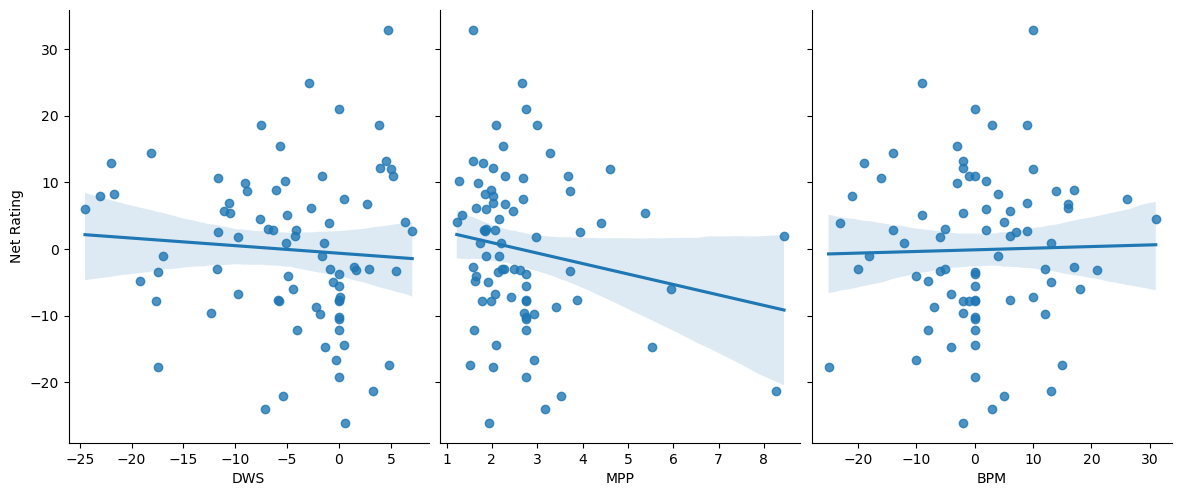

In [20]:
df_plot = pd.DataFrame(X_train_clean, columns=['DWS', 'MPP', 'BPM'])
df_plot['Net Rating'] = y_train

# 2. Create the plots
# 'kind="reg"' automatically adds the trendline
sns.pairplot(df_plot, x_vars=['DWS', 'MPP', 'BPM'], 
             y_vars='Net Rating', height=5, aspect=0.8, kind='reg')

plt.show()

In this chunk of code, I checked to see how accurate the model is by plotting the predicted values compared to the actual values. Based on how loosely plotted around the regression line the points are, this model wasnt very strong at predicting Reaves' impact based on the variables I used. This is also represented where the Mean Square Error for both regression models are around 99, with a root mean square error of around 10. In the context of basketball, this means that my model will predict the Lakers Net Rating within a range of +/- 10 of the actual rating. How well a player contributes to a team net rating is difficult to isolate, which is why the RMSE is quite large. 

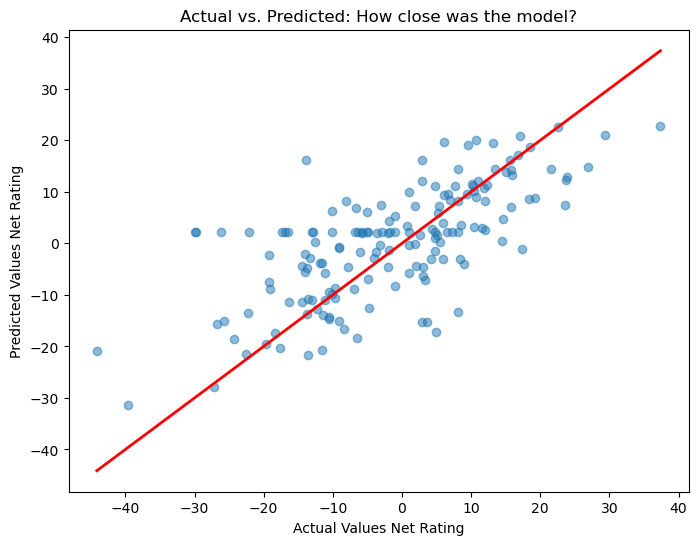

In [21]:
plt.figure(figsize=(8, 6))

# 1. Scatter plot of the actual data
plt.scatter(y_test, out_predict, alpha=0.5)

# 2. Draw the "Perfect Prediction" line (45-degree angle)
# This line represents where Actual == Predicted
min_val = min(y_test.min(), out_predict.min())
max_val = max(y_test.max(), out_predict.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='-', linewidth=2)

plt.xlabel("Actual Values Net Rating")
plt.ylabel("Predicted Values Net Rating")
plt.title("Actual vs. Predicted: How close was the model?")
plt.show()

In [22]:
Combined_df[["BPM","MPP","DWS"]].corr()

,BPM,MPP,DWS
BPM,1.000000,0.008838,0.420092
MPP,0.008838,1.000000,0.128340
DWS,0.420092,0.128340,1.000000


## Second Regression Analysis

After running this initial regression, I decided that I would use stats that are on a more individual player level. I also decided to use the Lasso regression model as it has stronger responses to non-useful input variables. 

### Defining Variables

This new regression will use the same dependent variable of the Lakers Net Rating but new independent variables:
- Points
- Assists
- Turnovers
- Minutes
- Box Plus Minus
- True Shooting %
- On Ball Possessions

Points, Assists, Turnovers, Minutes, and BPM have already been obtained from the previous regression model. The others need to be calculated.

In [29]:
# restating the Lakers and Austin Dateframes to make it easier to see variables
Lakers_df
Austin_df

,Rk,Gtm,Date,Unnamed: 3,Opp,Rslt,Tm,Opp.1,OT,FG,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,Possessions,Net Rating
0,1,1,19/10/21,NaN,GSW,L,114,121,NaN,45,...,5,40,45,21,7,4,18,25,116.36,-6.015813
1,2,2,22/10/21,NaN,PHO,L,105,115,NaN,34,...,12,34,46,25,7,3,16,26,102.76,-9.731413
2,3,3,24/10/21,NaN,MEM,W,121,118,NaN,45,...,9,27,36,29,10,12,17,14,101.68,2.950433
3,4,4,26/10/21,@,SAS,W,125,121,OT,50,...,9,47,56,20,8,10,13,21,118.68,3.370408
4,5,5,27/10/21,@,OKC,L,115,123,NaN,46,...,10,30,40,29,8,2,17,22,105.16,-7.607455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,78,78,6/04/25,@,OKC,W,126,99,NaN,46,...,8,35,43,25,6,2,17,15,100.48,26.871019
324,79,79,8/04/25,@,OKC,L,120,136,NaN,37,...,12,33,45,21,2,6,19,15,103.28,-15.491867
325,80,80,9/04/25,@,DAL,W,112,97,NaN,42,...,15,24,39,22,14,0,12,16,96.24,15.586035
326,81,81,11/04/25,NaN,HOU,W,140,109,NaN,53,...,4,38,42,28,11,1,13,15,107.00,28.971963


### Calculating True Shooting %

In [99]:
# calculating True shooting %

Austin_df["TS%"] = Austin_df["PTS"]/(2*(Austin_df["FGA"] + 0.44 * Austin_df["FTA"]))
Austin_df.head(5)

,Rk,Gcar,Gtm,Date,Team,Unnamed: 5,Opp,Result,GS,MP,...,TOV,PF,PTS,GmSc,+/-,Possessions_used,Minutes,MPP,TS%,OnBallPossessions
Games,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,1.0,19/10/21,LAL,NaN,GSW,"L, 114-121",Did Not Play,0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,NaN,NaN,0.00
1,1.0,1.0,2.0,22/10/21,LAL,NaN,PHO,"L, 105-115",NaN,12:00,...,0.0,1.0,8.0,6.0,17.0,4.00,12.000000,3.000000,1.000000,4.00
2,2.0,2.0,3.0,24/10/21,LAL,NaN,MEM,"W, 121-118",NaN,17:50,...,0.0,1.0,4.0,4.4,18.0,3.00,17.833333,5.944444,0.666667,3.00
3,3.0,3.0,4.0,26/10/21,LAL,@,SAS,"W, 125-121 (OT)",NaN,30:13:00,...,2.0,3.0,10.0,5.8,-13.0,7.88,30.216667,3.834602,0.850340,7.88
4,4.0,4.0,5.0,27/10/21,LAL,@,OKC,"L, 115-123",NaN,17:46,...,0.0,0.0,2.0,0.2,-5.0,4.00,17.766667,4.441667,0.250000,4.00


### Calculating On Ball Possessions

In [100]:
# On ball possessions is simply calculated by field goal attempts, free through attemps and trunovers

Austin_df["OnBallPossessions"] = Austin_df["FGA"] + 0.44 * Austin_df["FTA"] + Austin_df["TOV"]
Austin_df.head(5)

,Rk,Gcar,Gtm,Date,Team,Unnamed: 5,Opp,Result,GS,MP,...,TOV,PF,PTS,GmSc,+/-,Possessions_used,Minutes,MPP,TS%,OnBallPossessions
Games,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,1.0,19/10/21,LAL,NaN,GSW,"L, 114-121",Did Not Play,0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,NaN,NaN,0.00
1,1.0,1.0,2.0,22/10/21,LAL,NaN,PHO,"L, 105-115",NaN,12:00,...,0.0,1.0,8.0,6.0,17.0,4.00,12.000000,3.000000,1.000000,4.00
2,2.0,2.0,3.0,24/10/21,LAL,NaN,MEM,"W, 121-118",NaN,17:50,...,0.0,1.0,4.0,4.4,18.0,3.00,17.833333,5.944444,0.666667,3.00
3,3.0,3.0,4.0,26/10/21,LAL,@,SAS,"W, 125-121 (OT)",NaN,30:13:00,...,2.0,3.0,10.0,5.8,-13.0,7.88,30.216667,3.834602,0.850340,7.88
4,4.0,4.0,5.0,27/10/21,LAL,@,OKC,"L, 115-123",NaN,17:46,...,0.0,0.0,2.0,0.2,-5.0,4.00,17.766667,4.441667,0.250000,4.00


### Merging Dataframes

I merged the dataframes to make it easier for calculating on ball possessions as it uses some team variables.

In [31]:
# Combining the dataframes and then checking the names as they have some name similarities
Combined_df = pd.merge(Austin_df,Lakers_df, on="Date")
Combined_df.columns

Index(['Rk_x', 'Gcar', 'Gtm_x', 'Date', 'Team', 'Unnamed: 5', 'Opp_x',
       'Result', 'GS', 'MP', 'FG_x', 'FGA_x', 'FG%_x', '3P_x', '3PA_x',
       '3P%_x', '2P_x', '2PA_x', '2P%_x', 'eFG%_x', 'FT_x', 'FTA_x', 'FT%_x',
       'ORB_x', 'DRB_x', 'TRB_x', 'AST_x', 'STL_x', 'BLK_x', 'TOV_x', 'PF_x',
       'PTS', 'GmSc', '+/-', 'Possessions_used', 'Minutes', 'MPP', 'TS%',
       'OnBallPossessions', 'Rk_y', 'Gtm_y', 'Unnamed: 3', 'Opp_y', 'Rslt',
       'Tm', 'Opp.1', 'OT', 'FG_y', 'FGA_y', 'FG%_y', '3P_y', '3PA_y', '3P%_y',
       '2P_y', '2PA_y', '2P%_y', 'eFG%_y', 'FT_y', 'FTA_y', 'FT%_y', 'ORB_y',
       'DRB_y', 'TRB_y', 'AST_y', 'STL_y', 'BLK_y', 'TOV_y', 'PF_y',
       'Possessions', 'Net Rating'],
      dtype='object')

### Creating the Regression Dataframe

In [95]:
Regression_df = Combined_df[["Net Rating", "PTS","AST_x","TOV_x","Minutes","+/-","TS%","OnBallPossessions"]]
Regression_df

,Net Rating,PTS,AST_x,TOV_x,Minutes,+/-,TS%,OnBallPossessions
0,-6.015813,0.0,0.0,0.0,0.000000,0.0,NaN,0.00
1,-9.731413,8.0,0.0,0.0,12.000000,17.0,1.000000,4.00
2,2.950433,4.0,3.0,0.0,17.833333,18.0,0.666667,3.00
3,3.370408,10.0,1.0,2.0,30.216667,-13.0,0.850340,7.88
4,-7.607455,2.0,0.0,0.0,17.766667,-5.0,0.250000,4.00
...,...,...,...,...,...,...,...,...
323,26.871019,20.0,3.0,3.0,33.750000,14.0,0.629723,18.88
324,-15.491867,24.0,5.0,4.0,38.366667,-19.0,0.694444,21.28
325,15.586035,11.0,4.0,2.0,38.450000,19.0,0.505515,12.88
326,28.971963,23.0,6.0,5.0,33.000000,17.0,0.724181,20.88


## Training and Testing Lasso Model

In [96]:
X = Regression_df[["PTS","AST_x","TOV_x","Minutes","+/-","TS%","OnBallPossessions"]]
y = Regression_df["Net Rating"]

# the actual function that splits the data in half randomly but in a repeatable way
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, shuffle=True)

In [97]:
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# now we can replace the Nan's with the mean of the column 
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train)

# now we have clean input variables for the train model
# we will also clean up the test input variables now for simplicity
X_train_clean = imputer.transform(X_train)
X_test_clean = imputer.transform(X_test)

Lasso_model = Lasso(alpha=0.01)
Lasso_model.fit(X_train_clean,y_train)

out_predict = Lasso_model.predict(X_test_clean)

r2 = r2_score(y_test,out_predict)
mse = mean_squared_error(y_test, out_predict)
print(f"Y-Intercept: {Lasso_model.intercept_}")
print(f"R square: {r2}")
print(f"mean square error: {mse}")
print(f"Variables: {X.columns.tolist()}")
print(f"Coefficients: {Lasso_model.coef_}")

Y-Intercept: 1.1566133594762074
R square: 0.4464706483555406
mean square error: 104.43695681553605
Variables: ['PTS', 'AST_x', 'TOV_x', 'Minutes', '+/-', 'TS%', 'OnBallPossessions']
Coefficients: [ 0.25002747  0.19726434  1.36929297  0.0506621   0.80331631 -6.51098281
 -0.39336371]


## Redoing the Model with Adjusted Variables

Results from this regression suggest that I should remove the box plus minus and TS%, then replace on ball possessions with usage rate. This is because the Box plus minus is derived from the teams net rating so there is some multicolinearity. The True shooting percentage also has the same issue. For some reason there is a positive corelation for turnovers with net rating which doesn't make sense in basketball terms. I decided to replace the turnovers with the turnover rate as a more accurate way of capturing Austins turnovers.

### Calculating Turnover Percentage

In [98]:
# calculating tov%
# this is simply found using the turnovers field goal attempts and free throw attempts in the formula down below:
Combined_df["TOV%"] = Combined_df["TOV_x"]/Combined_df["FGA_x"] + 0.44 * Combined_df["FTA_x"] + Combined_df["TOV_x"]
Combined_df.columns

Index(['Rk_x', 'Gcar', 'Gtm_x', 'Date', 'Team', 'Unnamed: 5', 'Opp_x',
       'Result', 'GS', 'MP', 'FG_x', 'FGA_x', 'FG%_x', '3P_x', '3PA_x',
       '3P%_x', '2P_x', '2PA_x', '2P%_x', 'eFG%_x', 'FT_x', 'FTA_x', 'FT%_x',
       'ORB_x', 'DRB_x', 'TRB_x', 'AST_x', 'STL_x', 'BLK_x', 'TOV_x', 'PF_x',
       'PTS', 'GmSc', '+/-', 'Possessions_used', 'Minutes', 'MPP', 'TS%',
       'OnBallPossessions', 'Rk_y', 'Gtm_y', 'Unnamed: 3', 'Opp_y', 'Rslt',
       'Tm', 'Opp.1', 'OT', 'FG_y', 'FGA_y', 'FG%_y', '3P_y', '3PA_y', '3P%_y',
       '2P_y', '2PA_y', '2P%_y', 'eFG%_y', 'FT_y', 'FTA_y', 'FT%_y', 'ORB_y',
       'DRB_y', 'TRB_y', 'AST_y', 'STL_y', 'BLK_y', 'TOV_y', 'PF_y',
       'Possessions', 'Net Rating', 'TOV%', 'Usage Rate'],
      dtype='object')

### Calculating Usage Rate

In [101]:
# calculating Usage rate
# this is done by finding what Austin ends a possesion in on average within one game and then dividing it by how the Lakers 
# end possessions as a team. 
Combined_df["Usage Rate"] = 100 * ((Combined_df["FGA_x"] + 0.44 * Combined_df["FTA_x"] + Combined_df["TOV_x"])/
                                (Combined_df["FGA_y"] + 0.44 * Combined_df["FTA_y"] + Combined_df["TOV_y"]))
Combined_df.head(5)

,Rk_x,Gcar,Gtm_x,Date,Team,Unnamed: 5,Opp_x,Result,GS,MP,...,TRB_y,AST_y,STL_y,BLK_y,TOV_y,PF_y,Possessions,Net Rating,TOV%,Usage Rate
0,NaN,NaN,1.0,19/10/21,LAL,NaN,GSW,"L, 114-121",Did Not Play,0,...,45,21,7,4,18,25,116.36,-6.015813,NaN,0.000000
1,1.0,1.0,2.0,22/10/21,LAL,NaN,PHO,"L, 105-115",NaN,12:00,...,46,25,7,3,16,26,102.76,-9.731413,0.00,3.485535
2,2.0,2.0,3.0,24/10/21,LAL,NaN,MEM,"W, 121-118",NaN,17:50,...,36,29,10,12,17,14,101.68,2.950433,0.00,2.710517
3,3.0,3.0,4.0,26/10/21,LAL,@,SAS,"W, 125-121 (OT)",NaN,30:13:00,...,56,20,8,10,13,21,118.68,3.370408,3.28,6.171679
4,4.0,4.0,5.0,27/10/21,LAL,@,OKC,"L, 115-123",NaN,17:46,...,40,29,8,2,17,22,105.16,-7.607455,0.00,3.473428


In [103]:
# creating the dataframe for the regression model
Regression_df = Combined_df[["Net Rating","Usage Rate","TOV%","PTS","AST_x", "Minutes"]]
Regression_df

,Net Rating,Usage Rate,TOV%,PTS,AST_x,Minutes
0,-6.015813,0.000000,NaN,0.0,0.0,0.000000
1,-9.731413,3.485535,0.000000,8.0,0.0,12.000000
2,2.950433,2.710517,0.000000,4.0,3.0,17.833333
3,3.370408,6.171679,3.280000,10.0,1.0,30.216667
4,-7.607455,3.473428,0.000000,2.0,0.0,17.766667
...,...,...,...,...,...,...
323,26.871019,17.404130,4.080000,20.0,3.0,33.750000
324,-15.491867,18.459403,9.613333,24.0,5.0,38.366667
325,15.586035,11.578569,3.080000,11.0,4.0,38.450000
326,28.971963,18.810811,6.213333,23.0,6.0,33.000000


### Running Regression with Adjusted Variables

In [115]:
# this splits the df into their respective variables
X = Regression_df[['PTS','AST_x','TOV%','Minutes','Usage Rate']].copy()
y = Regression_df['Net Rating']

# this simply ensures that the model doesn't think that there are infinite values in the data for when Austin missed a game
X = X.replace([np.inf, -np.inf], np.nan)
y = y.replace([np.inf, -np.inf], np.nan)

# this is the same test and train split from above 
# we use only 20% of the data to train the model
# random state 42 insures that the train and test model can be repeated
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# this helps make it easier to train and test the model by putting everything into one variable
# It essentially automises everything within the pipeline so that it is done in one step instead of multiple
# the Imputer replaces any values that are NaN with the mean of that column
# The scaler is so that each variable has a mean of 0 and a st deviation of 1
# The lasso part fits the model with a cross fold validation of 5 and the ability to be reproduced (random state 42)
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),   
    ('scaler', StandardScaler()),                  
    ('lasso', LassoCV(cv=5, random_state=42))     
])

# this fits everything from the pipline using the train variables
pipeline.fit(X_train, y_train)

# creating variables to compare r square
# this is to check model to see how well it fits on the test data based on the trained data
r2_train = pipeline.score(X_train, y_train)
r2_test = pipeline.score(X_test, y_test)
print("R^2 (train):", r2_train)
print("R^2 (test):", r2_test)

# This calculates the root mean square error based on the test variables
y_pred_test = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)

# this simply prints all of the coefficients and values, along with the intercept and rmse
lasso_model = pipeline.named_steps['lasso']
print("Intercept:", lasso_model.intercept_)
coef_df = pd.DataFrame({
    'Predictor': X.columns,
    'Coefficient': lasso_model.coef_
})
print(coef_df)
print("Root Mean Squared Error", rmse)

R^2 (train): 0.07179555487667655
R^2 (test): 0.08611327786119594
Intercept: 0.2560734202294167
    Predictor  Coefficient
0         PTS     3.592848
1       AST_x     3.271275
2        TOV%    -0.195774
3     Minutes     0.385910
4  Usage Rate    -3.907307
Root Mean Squared Error 13.197223717344139


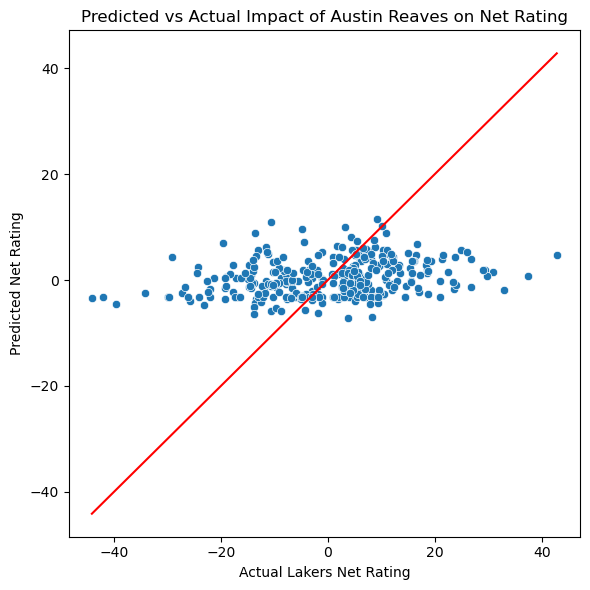

In [111]:
# Predicted values using pipeline
y_pred = pipeline.predict(X)

# this chunk of code creates the visualisation of the predicted results and the actual results of the model
plt.figure(figsize=(6,6))
sns.scatterplot(x=y, y=y_pred)
# The red line shows where y=x, so essentially where the predicted is the same as the actual result\
# if the results are tightly clustered around the line, the model does a great job predicting accurately
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r-')  
plt.xlabel("Actual Lakers Net Rating")
plt.ylabel("Predicted Net Rating")
plt.title("Predicted vs Actual Impact of Austin Reaves on Net Rating")
plt.tight_layout()
plt.show()

## Conclusion

Based on the results of this final model, it is clear that Austin's main contributing stats are points and assists, where 1 point or assist improve the Lakers net rating by 3.6 and 3.27. This is assuming that all other variables are held constant at 0. How many minutes Austin plays has a slight positive imnpact where 1 minute of playing time increases net rating by around 0.39. As expected, turnover rate has a negative impact on the net rating where a 1% turnover rate decreases the net rating by 0.195. Finally the biggest indicator is the usage rate which had a coefficient of -3.9, which indicates that relying on Austin for ball carrying or using the ball more often has a negative impact on the Lakers net rating. This makes sense as he has been more of a role player in the previous few years alongside other stars such as Lebron James and Anthony Davis. Including this years stats may change that as he has been stepping up as a second option behind Luca Doncic with Lebron out injured. The intercept is around 0.26 which suggests when Austin is not playing, the Lakers net rating is 0.26. This is possible but probably not the case in this example as Austin is more of a role player. As far as predicting his impact, there is a lot of different factors that go into determining an individual players impact such as Austins teammates, coaching staff, and the opposing team. All of these factors have so much variability which makes sense why the R Square is only 8%. This means that only 8% of the variation can be explained from the model, which in most cases isn't very strong but due to the huge variability from the variables mentioned before, this small R Sqaure makes sense. The Root Mean Square Error of 13 means that the model is off by about 13 when predicting the Lakers Net Rating. This again makes sense based on the noise and variable of all other variables in basketball. In short, Austin does positively impact the Lakers, particular on the scoring and playmaking side, while excessive usage of the ball can negatively impact the Lakers. 